# Start of the Project

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import gc
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn.cluster import SpectralClustering
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [ ]:
CustomerData = pd.read_csv('/content/drive/MyDrive/UnSupervisedMachineLearningData/customers.csv',sep=',')

In [ ]:
ArticlesData = pd.read_csv('/content/drive/MyDrive/UnSupervisedMachineLearningData/articles.csv',sep=',', dtype={'article_id': str})

In [ ]:
TransactionData = pd.read_csv('/content/drive/MyDrive/UnSupervisedMachineLearningData/transactions_train.csv',sep=',', dtype={'article_id': str} , parse_dates=['t_dat'])

In [ ]:
ArticlesData.columns

Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')

## Cleaning customer's data

In [ ]:
CustomerData = CustomerData.drop(['postal_code'],axis=1)

In [ ]:
def FixCustomerDataFrame(CustomerData):
  for col in CustomerData.columns:
    if col == "FN":
      CustomerData['FN'] = CustomerData['FN'].fillna(0)
    if col == "Active":
      CustomerData['Active'] = CustomerData['Active'].fillna(0)
    if col == "club_member_status":
      CustomerData['club_member_status'] = CustomerData['club_member_status'].replace({np.nan :0, 'PRE-CREATE':1, 'ACTIVE':2, 'LEFT CLUB':-1})
    if col == "fashion_news_frequency":
      CustomerData['fashion_news_frequency'] = CustomerData['fashion_news_frequency'].replace({np.nan :0, 'None':0 , 'NONE':0 , 'Regularly':1 , 'Monthly' : 2 })


In [ ]:
FixCustomerDataFrame(CustomerData)

In [ ]:
CustomerData = CustomerData.dropna(subset=['age'])

In [ ]:
artilcles_unique_count_per_column = ArticlesData.nunique()

In [ ]:
artilcles_unique_count_per_column

article_id                      105542
product_code                     47224
prod_name                        45875
product_type_no                    132
product_type_name                  131
product_group_name                  19
graphical_appearance_no             30
graphical_appearance_name           30
colour_group_code                   50
colour_group_name                   50
perceived_colour_value_id            8
perceived_colour_value_name          8
perceived_colour_master_id          20
perceived_colour_master_name        20
department_no                      299
department_name                    250
index_code                          10
index_name                          10
index_group_no                       5
index_group_name                     5
section_no                          57
section_name                        56
garment_group_no                    21
garment_group_name                  21
detail_desc                      43404
dtype: int64

In [ ]:
ArticlesDataFiltered = ArticlesData[['article_id','index_group_name']]

Fitlering transaciton data only data beyond Sep 2020 is being used

In [ ]:
TransactionDataFrameFiltered = TransactionData[(TransactionData['t_dat'] >= "2020-09-01")]

In [ ]:
transactionsAndArticles = pd.merge(TransactionDataFrameFiltered, ArticlesDataFiltered, left_on='article_id', right_on='article_id', how='inner')

In [ ]:
transactionsAndArticles = transactionsAndArticles[['customer_id','article_id','price','index_group_name']]

In [ ]:
transactionsAndArticles

,customer_id,article_id,price,index_group_name
0,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,0777148006,0.013542,Ladieswear
1,5ac5e1825104ed5fe3333e75b9337eebc4b45ad761056b...,0777148006,0.013542,Ladieswear
2,0dcf3023ea1992a78a1fcc769b6befc956f7308186496d...,0777148006,0.013542,Ladieswear
3,28b30893bbe946358103760387e3dcd09fdb7b077a942f...,0777148006,0.042356,Ladieswear
4,278f23c7fac720c2b96b25455d640860bdfa8bb3c867cf...,0777148006,0.013542,Ladieswear
...,...,...,...,...
798264,f71529889de7a28df0015fad0a043941ecc98883286ef0...,0737994021,0.030492,Baby/Children
798265,f79e372e21c1359dfebc7da0bf7f321d55e47b3275c351...,0533261032,0.033881,Baby/Children
798266,f82c91decd5f9abd0a7a72eae0d4911b00ed4f5b4f04f9...,0865792012,0.008458,Baby/Children
798267,f96661e9e56449885d4c4b90d3227e4abea5e0d2382e2d...,0772659001,0.016932,Ladieswear


In [ ]:
CountsDataFrame = transactionsAndArticles.pivot_table(index='customer_id', columns='index_group_name', aggfunc='size', fill_value=0)

In [ ]:
TotalMoneySpent = transactionsAndArticles.groupby('customer_id')['price'].sum().reset_index(name='TotalMoneySpent')

In [ ]:
TotalMoneySpent

,customer_id,TotalMoneySpent
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.050831
1,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.061000
2,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,0.076237
3,000172a9c322560c849754ffbdfdb2180d408aa7176b94...,0.101644
4,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,0.237966
...,...,...
189505,fffd0248a95c2e49fee876ff93598e2e20839e51b9b767...,0.166000
189506,fffd870c6324ad3bda24e4d6aeae221c199479086bfdfd...,0.059288
189507,fffef3b6b73545df065b521e19f64bf6fe93bfd450ab20...,0.398119
189508,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0.135492


In [ ]:
CustomerAndProductData = pd.merge(CustomerData, CountsDataFrame, left_on='customer_id', right_on='customer_id', how='inner')

In [ ]:
CustomerAndProductDataWithTotalMoneySpent = pd.merge(CustomerAndProductData, TotalMoneySpent, left_on='customer_id', right_on='customer_id', how='inner')

In [ ]:
CustomerAndProductDataWithTotalMoneySpentWithoutIds = CustomerAndProductDataWithTotalMoneySpent.drop('customer_id',axis=1)

In [ ]:
CustomerAndProductDataWithTotalMoneySpentWithoutIds

,FN,Active,club_member_status,fashion_news_frequency,age,Baby/Children,Divided,Ladieswear,Menswear,Sport,TotalMoneySpent
0,0.0,0.0,2,0,49.0,0,0,1,0,0,0.050831
1,0.0,0.0,2,0,24.0,0,0,0,0,1,0.061000
2,0.0,0.0,2,0,20.0,0,2,0,0,0,0.076237
3,0.0,0.0,2,0,45.0,0,0,0,3,0,0.101644
4,1.0,1.0,2,1,44.0,0,3,6,0,1,0.237966
...,...,...,...,...,...,...,...,...,...,...,...
188625,1.0,1.0,2,1,20.0,0,0,6,0,0,0.166000
188626,1.0,1.0,2,1,45.0,0,0,2,0,0,0.059288
188627,1.0,1.0,2,1,29.0,0,2,9,0,0,0.398119
188628,0.0,0.0,2,0,24.0,0,0,2,0,4,0.135492


In [ ]:
scaler = StandardScaler()
scaler.fit(CustomerAndProductDataWithTotalMoneySpentWithoutIds)

StandardScaler()

In [ ]:
scaled_ds = pd.DataFrame(scaler.transform(CustomerAndProductDataWithTotalMoneySpentWithoutIds),columns= CustomerAndProductDataWithTotalMoneySpentWithoutIds.columns )

In [ ]:
scaled_ds

,FN,Active,club_member_status,fashion_news_frequency,age,Baby/Children,Divided,Ladieswear,Menswear,Sport,TotalMoneySpent
0,-0.895844,-0.883584,0.114507,-0.897432,0.962890,-0.151933,-0.522192,-0.493428,-0.236131,-0.246660,-0.520337
1,-0.895844,-0.883584,0.114507,-0.897432,-0.817514,-0.151933,-0.522192,-0.797033,-0.236131,0.777881,-0.462048
2,-0.895844,-0.883584,0.114507,-0.897432,-1.102379,-0.151933,0.530608,-0.797033,-0.236131,-0.246660,-0.374710
3,-0.895844,-0.883584,0.114507,-0.897432,0.678025,-0.151933,-0.522192,-0.797033,2.518039,-0.246660,-0.229084
4,1.116266,1.131754,0.114507,1.111953,0.606809,-0.151933,1.057009,1.024597,-0.236131,0.777881,0.552288
...,...,...,...,...,...,...,...,...,...,...,...
188625,1.116266,1.131754,0.114507,1.111953,-1.102379,-0.151933,-0.522192,1.024597,-0.236131,-0.246660,0.139792
188626,1.116266,1.131754,0.114507,1.111953,0.678025,-0.151933,-0.522192,-0.189823,-0.236131,-0.246660,-0.471860
188627,1.116266,1.131754,0.114507,1.111953,-0.461433,-0.151933,0.530608,1.935412,-0.236131,-0.246660,1.470251
188628,-0.895844,-0.883584,0.114507,-0.897432,-0.817514,-0.151933,-0.522192,-0.189823,-0.236131,3.851503,-0.035077


## PCA

In [ ]:
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,188630.0,-6.121147e-17,1.729528,-3.161603,-1.551808,-1.470378,1.922166,3.209136
col2,188630.0,3.124610e-17,1.439690,-1.240566,-0.831933,-0.462604,0.276752,43.116010
col3,188630.0,-4.137895e-17,1.028853,-4.957290,-0.741205,-0.302890,0.629262,21.165044


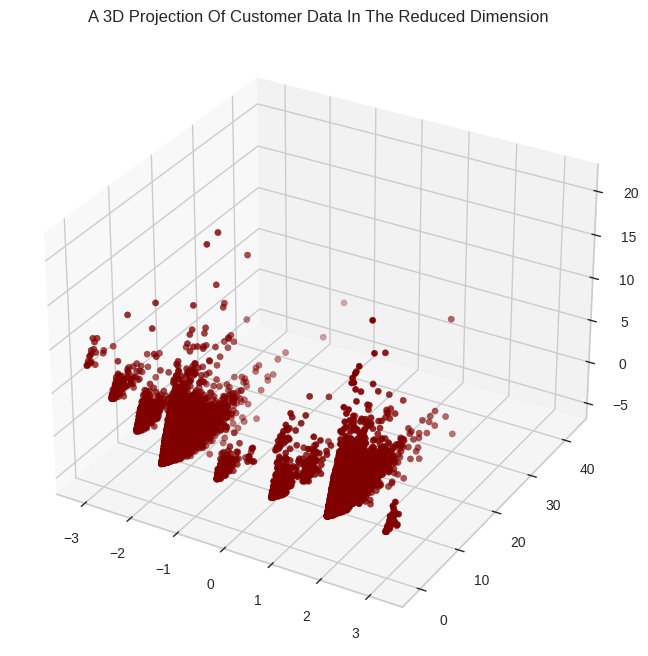

In [ ]:
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Customer Data In The Reduced Dimension")
plt.show()

Elbow Method to determine the number of clusters to be formed:


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

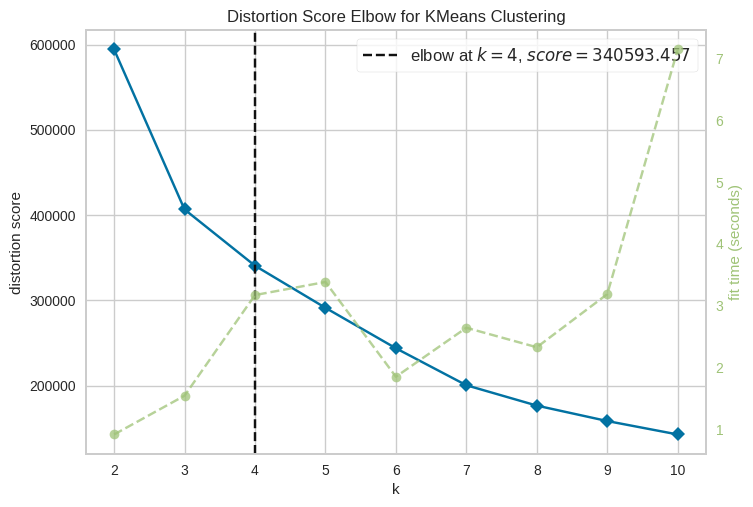

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [ ]:
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [ ]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(PCA_ds)
labels = kmeans.labels_
CustomerAndProductDataWithTotalMoneySpent["cluster"] = labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


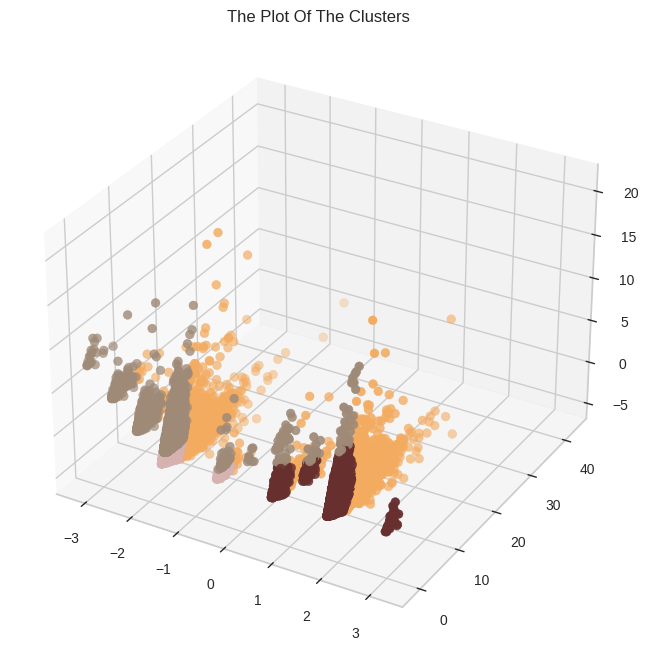

In [ ]:
#Plotting the clusters
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=CustomerAndProductDataWithTotalMoneySpent["cluster"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

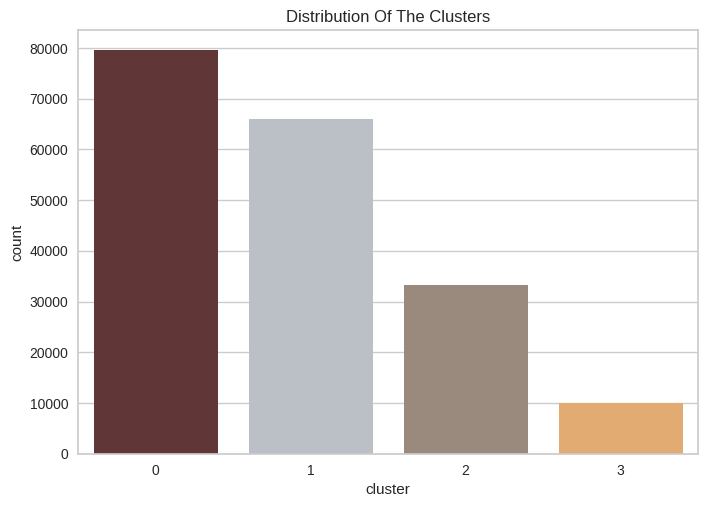

In [ ]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=CustomerAndProductDataWithTotalMoneySpent["cluster"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

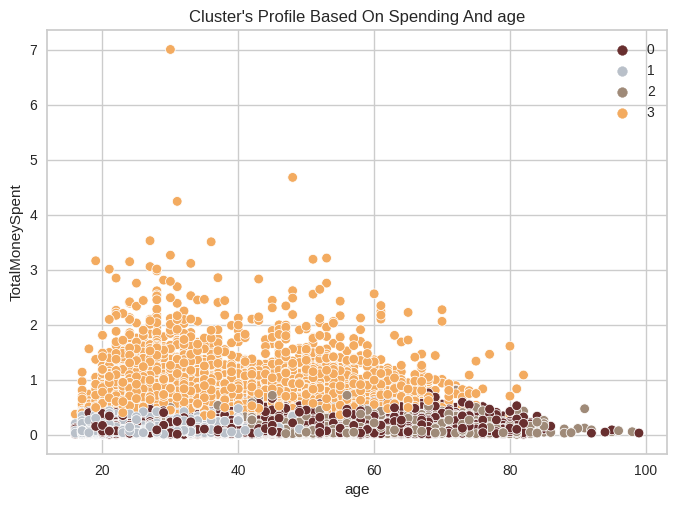

In [ ]:
pl = sns.scatterplot(data = CustomerAndProductDataWithTotalMoneySpent,x=CustomerAndProductDataWithTotalMoneySpent["age"], y=CustomerAndProductDataWithTotalMoneySpent["TotalMoneySpent"],hue=CustomerAndProductDataWithTotalMoneySpent["cluster"], palette= pal)
pl.set_title("Cluster's Profile Based On Spending And age")
plt.legend()
plt.show()

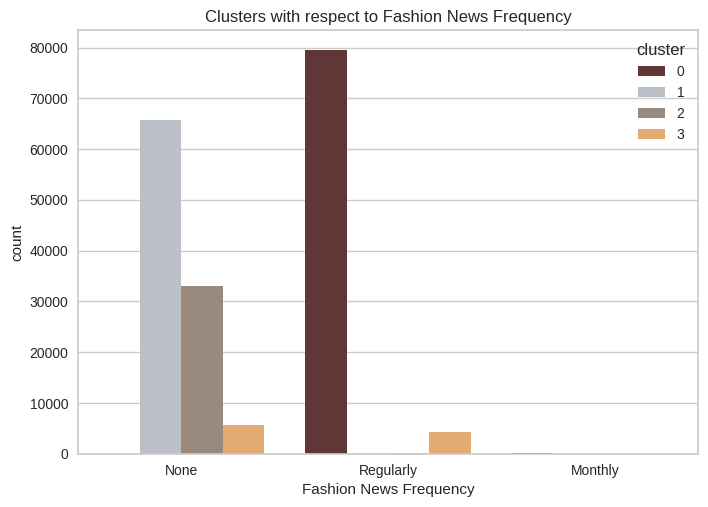

In [ ]:
plt.figure()
pl = sns.countplot(x=CustomerAndProductDataWithTotalMoneySpent["fashion_news_frequency"],hue=CustomerAndProductDataWithTotalMoneySpent["cluster"], palette= pal)
pl.set_title("Clusters with respect to Fashion News Frequency")
pl.set_xlabel("Fashion News Frequency")
plt.gca().set_xticklabels(['None', 'Regularly', 'Monthly'])
plt.show()

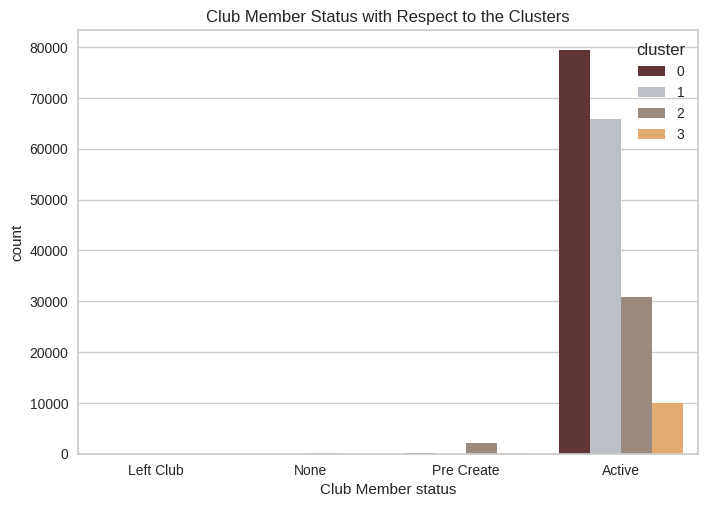

In [ ]:
plt.figure()
pl = sns.countplot(x=CustomerAndProductDataWithTotalMoneySpent["club_member_status"],hue=CustomerAndProductDataWithTotalMoneySpent["cluster"], palette= pal)
pl.set_title("Club Member Status with Respect to the Clusters")
pl.set_xlabel("Club Member status")
plt.gca().set_xticklabels(['Left Club', 'None', 'Pre Create', 'Active'])
plt.show()

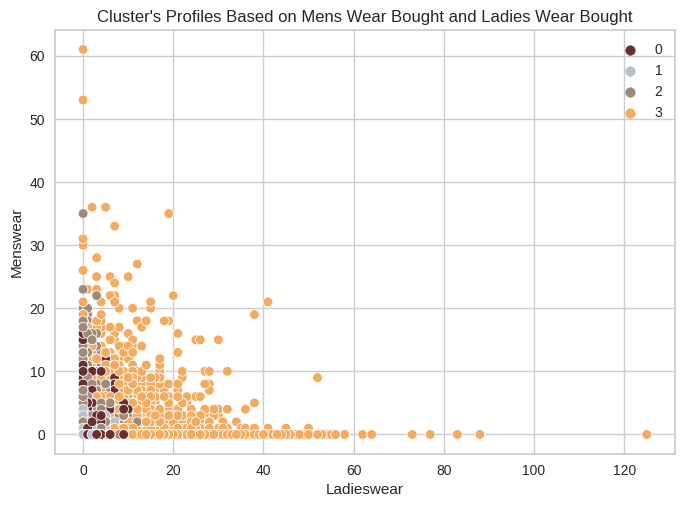

In [ ]:
pl = sns.scatterplot(data = CustomerAndProductDataWithTotalMoneySpent,x=CustomerAndProductDataWithTotalMoneySpent["Ladieswear"], y=CustomerAndProductDataWithTotalMoneySpent["Menswear"],hue=CustomerAndProductDataWithTotalMoneySpent["cluster"], palette= pal)
pl.set_title("Cluster's Profiles Based on Mens Wear Bought and Ladies Wear Bought")
plt.legend()
plt.show()

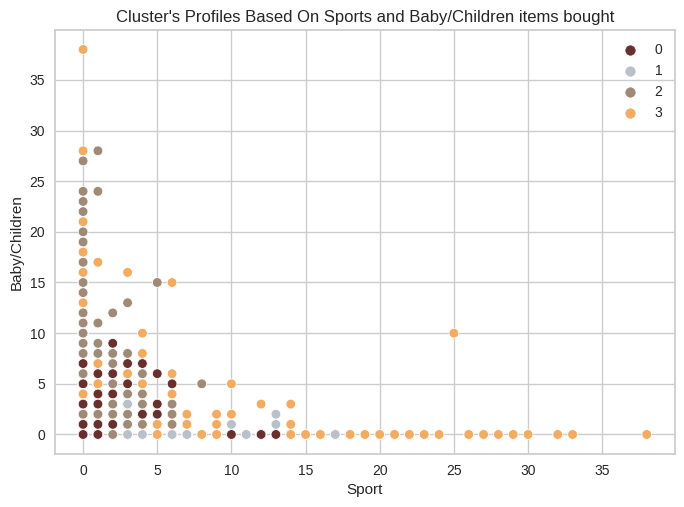

In [ ]:
pl = sns.scatterplot(data = CustomerAndProductDataWithTotalMoneySpent,x=CustomerAndProductDataWithTotalMoneySpent["Sport"], y=CustomerAndProductDataWithTotalMoneySpent["Baby/Children"],hue=CustomerAndProductDataWithTotalMoneySpent["cluster"], palette= pal)
pl.set_title("Cluster's Profiles Based On Sports and Baby/Children items bought")
plt.legend()
plt.show()

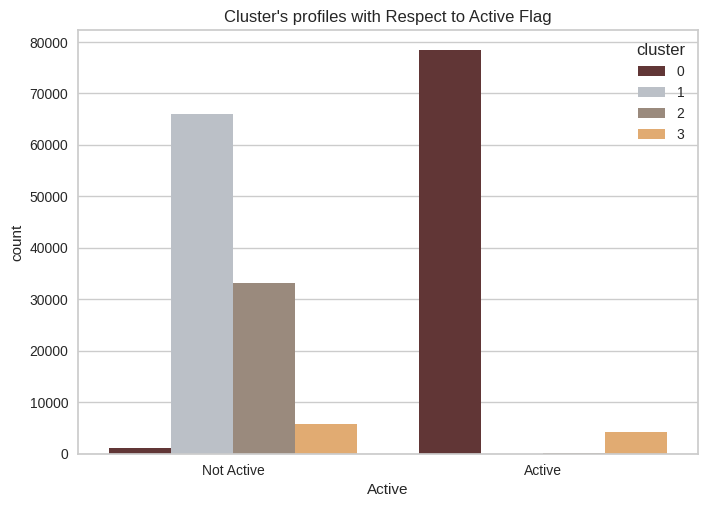

In [ ]:
plt.figure()
pl = sns.countplot(x=CustomerAndProductDataWithTotalMoneySpent["Active"],hue=CustomerAndProductDataWithTotalMoneySpent["cluster"], palette= pal)
pl.set_title("Cluster's profiles with Respect to Active Flag")
plt.gca().set_xticklabels(['Not Active','Active'])
plt.show()

Creating the Recommendaiton Function

In [ ]:
CustomerClusterDataWithTranasctionalData = pd.merge(transactionsAndArticles, CustomerAndProductDataWithTotalMoneySpent, left_on='customer_id', right_on='customer_id', how='inner')

In [ ]:
CustomerClusterDataWithTranasctionalData = CustomerClusterDataWithTranasctionalData[['customer_id','cluster','article_id','price','index_group_name']]

In [ ]:
CustomerClusterDataWithTranasctionalData

,customer_id,cluster,article_id,price,index_group_name
0,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,0,0777148006,0.013542,Ladieswear
1,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,0,0835801001,0.018627,Ladieswear
2,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,0,0923134005,0.012695,Ladieswear
3,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,0,0865929003,0.016932,Ladieswear
4,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,0,0935858001,0.016932,Divided
...,...,...,...,...,...
795333,d5013b57392ac330a87fdf6c04d439594bfb8776afe035...,2,0828321001,0.033881,Baby/Children
795334,d98a24c79ecfe9e1e52f9ff5d0ffc4f84740c317591530...,0,0818890001,0.016932,Ladieswear
795335,d98a24c79ecfe9e1e52f9ff5d0ffc4f84740c317591530...,0,0818890001,0.016932,Ladieswear
795336,e991c3fcb6730496d8ba1c521121d55fb1dfd0ab98b748...,0,0930405002,0.067780,Ladieswear


In [ ]:
CustomerClusterDataWithTranasctionalDataEachArticleCount = CustomerClusterDataWithTranasctionalData.groupby(['article_id', 'cluster','index_group_name']).size().reset_index(name='NoOfTimesBought')

In [ ]:
CustomerClusterDataWithTranasctionalDataEachArticleCount

,article_id,cluster,index_group_name,NoOfTimesBought
0,0108775044,1,Ladieswear,8
1,0108775044,2,Ladieswear,2
2,0110065011,0,Ladieswear,1
3,0111565001,0,Ladieswear,33
4,0111565001,1,Ladieswear,33
...,...,...,...,...
67789,0953763001,3,Ladieswear,9
67790,0956217002,0,Ladieswear,3
67791,0956217002,1,Ladieswear,1
67792,0956217002,2,Ladieswear,6


Recommendaiton Funciton Based on Clusters

In [ ]:
def RecommendItems(user_id,index_group_name):
  clusterid = CustomerClusterDataWithTranasctionalData.loc[CustomerClusterDataWithTranasctionalData['customer_id'] == user_id]['cluster'][0]
  ariclesid = CustomerClusterDataWithTranasctionalData.loc[(CustomerClusterDataWithTranasctionalData['customer_id'] == user_id) & (CustomerClusterDataWithTranasctionalData['index_group_name'] == index_group_name)]['article_id']
  articlesalreadybought = ariclesid.unique()
  ClusterAndIndexDataForthatCustomer = CustomerClusterDataWithTranasctionalDataEachArticleCount.loc[(CustomerClusterDataWithTranasctionalDataEachArticleCount['cluster'] == clusterid) & (CustomerClusterDataWithTranasctionalDataEachArticleCount['index_group_name'] == index_group_name) & ~CustomerClusterDataWithTranasctionalDataEachArticleCount['article_id'].isin(articlesalreadybought)]
  TopTenRecommendedItems = ClusterAndIndexDataForthatCustomer.sort_values(by='NoOfTimesBought', ascending=False).head(10)
  return TopTenRecommendedItems['article_id'].tolist()


In [ ]:
RecommendItems('0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37e011580a479e80aa94','Ladieswear')

['0909370001',
 '0915526001',
 '0751471001',
 '0918522001',
 '0924243001',
 '0751471043',
 '0915529003',
 '0896152002',
 '0898694001',
 '0863595006']